# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

## Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output

from ddpg_agent import Agent
import time

try:
    env.close()
except:
    pass

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = UnityEnvironment(file_name='Reacher20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
def ddpg(agent,n_episodes=200, max_t=1000, last_episode_number=1):
    
    print('\rTraining launched.')
    
    end_printed = False
    best_score = 0

    scores_window = deque(maxlen=100)
    scores = []
    total_time_elapsed = 0
    for i_episode in range(last_episode_number, n_episodes+1):
        begin = time.time()
        avg_score = 0
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
#         print('Reset environment...')
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores_t = np.zeros(num_agents)                        # initialize the score (for each agent)
        agent.reset()
        score = 0
        for t_step in range(max_t):
            actions = agent.act(states)     
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished   
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores_t += rewards
            if np.any(dones):
                break
        
        score = np.mean(scores_t)
        scores_window.append(score)
        avg_score = np.mean(scores_window)
        scores.append(score)        
        
        end = time.time()
        diff = end - begin
        print("\rEpisode {:}\t Average Score {:.2f}\tMax Score {:.2f}\tTime {:.2f} s".format(i_episode, avg_score, scores_t.max(), diff), end="")
        total_time_elapsed += diff
        
        if i_episode % 10 == 0:
            print("\rEpisode {:}\t Average Score {:.2f}\tMax Score {:.2f}".format(i_episode, avg_score, scores_t.max()))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_'+str(i_episode)+'.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_'+str(i_episode)+'.pth')
            
        if avg_score >= 30 and avg_score > best_score:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            best_score = avg_score
            if not end_printed:
                print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\t\tTime Elapsed {:.2f} s \n\n'.format(i_episode, avg_score,total_time_elapsed))
                end_printed = True              

    return scores

In [6]:
from workspace_utils import active_session

seed = 16
agent = Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=seed)

with active_session():
    scores = ddpg(agent)

Training launched.
Episode 10	 Average Score 0.57	Max Score 1.85	Time 11.66 s
Episode 20	 Average Score 0.80	Max Score 4.62	Time 12.77 s
Episode 30	 Average Score 1.47	Max Score 5.93	Time 13.96 s
Episode 40	 Average Score 2.27	Max Score 9.30	Time 15.10 ss
Episode 50	 Average Score 3.61	Max Score 17.80	Time 16.42 s
Episode 60	 Average Score 5.11	Max Score 24.24	Time 16.54 s
Episode 70	 Average Score 6.80	Max Score 28.89	Time 16.62 s
Episode 80	 Average Score 8.68	Max Score 36.81	Time 16.74 s
Episode 90	 Average Score 10.53	Max Score 33.71	Time 16.19 s
Episode 100	 Average Score 12.24	Max Score 38.09	Time 16.34 s
Episode 110	 Average Score 15.77	Max Score 39.12	Time 16.89 s
Episode 120	 Average Score 18.92	Max Score 37.53	Time 16.43 s
Episode 130	 Average Score 21.82	Max Score 38.09	Time 16.47 s
Episode 140	 Average Score 24.48	Max Score 38.73	Time 16.37 s
Episode 150	 Average Score 26.91	Max Score 36.95	Time 16.73 s
Episode 160	 Average Score 28.92	Max Score 36.02	Time 16.52 s
Episode 1

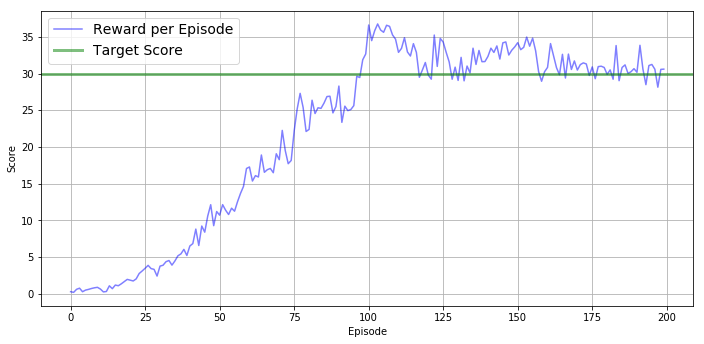

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

ax.plot(scores, "-", c="blue", alpha=0.5)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(30, c="green", linewidth=3, alpha=0.5)
ax.legend(["Reward per Episode", "Target Score"])

fig.tight_layout()